In [1]:
##IMPORTS
#Basics
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # create directories in the local filesystem
from tqdm import tqdm # plot progress bars
import plotly.express as px

#PyTorch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import  DataLoader
from torch import nn


import torch.optim as optim
import torch.nn.functional as F

#Pytoprch lightning


#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For latent space exploration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models definitions and training models

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
### Download the data and create dataset
data_dir = '../dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST('../dataset', train=True, download=False)


In [4]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform


In [5]:
class Discriminator(nn.Module):
    def __init__(self,dp=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


In [12]:
batch_size =32

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
learning_rate = 0.0001
regularization = 0.
num_epochs = 5

In [8]:
discriminator = Discriminator()
generator = Generator()

In [9]:
### Define the loss function
loss_fn = nn.BCELoss()

### Define an optimizer (both for the encoder and the decoder!)
# params_to_optimize = [
#     {'params': discriminator.parameters()},
#     {'params': generator.parameters()}
# ]
# optimizer = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
discriminator.to(device)
generator.to(device)

Selected device: cpu


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [8]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)


In [10]:
lr = 0.0001
num_epochs = 2
loss_function = nn.BCELoss()
batch_size = 32

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [15]:
def sample_generator_to_train_discriminator(real_samples, device, batch_size):
    
    # Assign label 1 to real images
    real_samples = real_samples.to(device)
    real_labels  = torch.ones((batch_size,1)).to(device)
    
    # Generate some fake images
    noise_sample = torch.randn((batch_size, 100)).to(device)
    fake_samples = generator(noise_sample)
    fake_labels  = torch.zeros((batch_size, 1)).to(device)
    
    # Concatenate all the data which will serve as training dataset for the discriminator
    all_samples = torch.cat((real_samples,fake_samples))
    all_labels  = torch.cat((real_labels, fake_labels))
    
    return all_samples, all_labels,real_labels


In [16]:
loss_discriminator_ = []
loss_generator_     = []

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
        
        
        ### Data for training the discriminator
        all_samples,all_samples_labels,real_samples_labels = sample_generator_to_train_discriminator(real_samples, device, batch_size)

        
        ### Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_fn(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ### Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator

        ### Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_fn(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            loss_discriminator_.append(loss_discriminator)
            loss_generator_.append(loss_generator)
            #Save model
            torch.save(generator.state_dict(), f'./Models/encoder_epoch_{epoch}.pth')


Epoch: 0 Loss D.: 0.7166830897331238
Epoch: 0 Loss G.: 0.46276816725730896


KeyboardInterrupt: 

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
        
        
        ### Data for training the discriminator
        real_samples         = real_samples.to(device=device)
        real_samples_labels  = torch.ones((batch_size, 1)).to(device=device)     # assign the "real" label to the samples
        
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator
        generated_samples    = generator(latent_space_samples)                   # Generate fake images
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)#  assign the "fake" label to the samples
        
        all_samples        = torch.cat((real_samples, generated_samples))        # Concatenate fake and real samples
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)) # Concatenate fake and real labels

        
        ### Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ### Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator

        ### Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
            #Save model
            torch.save(generator.state_dict(), f'./Models/encoder_epoch_{epoch}.pth')


Epoch: 0 Loss D.: 0.6585246920585632
Epoch: 0 Loss G.: 0.49052295088768005
Epoch: 1 Loss D.: 0.16562753915786743
Epoch: 1 Loss G.: 2.1809473037719727
Epoch: 2 Loss D.: 0.09341782331466675
Epoch: 2 Loss G.: 2.989243268966675
Epoch: 3 Loss D.: 0.13858026266098022
Epoch: 3 Loss G.: 3.4544970989227295
Epoch: 4 Loss D.: 0.09378595650196075
Epoch: 4 Loss G.: 3.478379011154175
Epoch: 5 Loss D.: 0.16397543251514435
Epoch: 5 Loss G.: 2.797163963317871
Epoch: 6 Loss D.: 0.37352699041366577
Epoch: 6 Loss G.: 2.3098366260528564
Epoch: 7 Loss D.: 0.2255706638097763
Epoch: 7 Loss G.: 2.105267286300659
Epoch: 8 Loss D.: 0.3080088496208191
Epoch: 8 Loss G.: 1.602288007736206
Epoch: 9 Loss D.: 0.18933814764022827
Epoch: 9 Loss G.: 1.87074613571167
Epoch: 10 Loss D.: 0.254824161529541
Epoch: 10 Loss G.: 1.880683422088623
Epoch: 11 Loss D.: 0.32105717062950134
Epoch: 11 Loss G.: 1.6206187009811401
Epoch: 12 Loss D.: 0.3753243386745453
Epoch: 12 Loss G.: 1.670541763305664
Epoch: 13 Loss D.: 0.435895264148

In [13]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

NameError: name 'device' is not defined

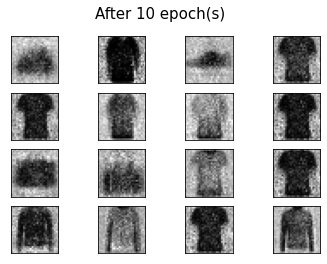

In [29]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    plt.suptitle(f'After {j} epoch(s)',fontsize=15)

In [21]:
    # Load network parameters
generator.load_state_dict(torch.load(f'Models/encoder_epoch_{j}.pth'))

latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

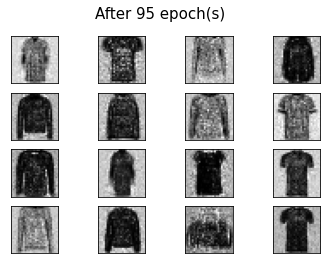

In [30]:
every_n = [i for i in range(100)]
for j in every_n[::5]:
    # Load network parameters
    generator.load_state_dict(torch.load(f'Models/encoder_epoch_{j}.pth'))

    latent_space_samples = torch.randn(batch_size, 100).to(device=device)
    generated_samples = generator(latent_space_samples)

    generated_samples = generated_samples.cpu().detach()
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(f'After {j} epoch(s)',fontsize=15)    
    plt.savefig(f"./Img/{j}.png")

In [31]:
import imageio
from IPython.display import Image

In [38]:
# Build GIF
every_n = [i for i in range(100)]
gif_files = [f"./Img/{j}.png" for j in every_n[::5]]
with imageio.get_writer(f'GIF.gif', mode='I') as writer:
    for filename in gif_files:
        image = imageio.imread(filename)
        writer.append_data(image)
    
gif = imageio.mimread(f'GIF.gif')
gif_speed_up = f'GIF.gif'
imageio.mimsave(gif_speed_up, gif, fps=2)

In [41]:
Image(url='GIF.gif')  

In [23]:
every_n = [i for i in range(100)]
every_n[::5]

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [ ]:
def train_discriminator():
    discriminator.zero_grad()
    output_discriminator = discriminator(all_samples)
    loss_discriminator   = loss_function(output_discriminator, all_samples_labels)
    loss_discriminator.backward()
    optimizer_discriminator.step()

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
        
        
        ### Data for training the discriminator
        real_samples         = real_samples.to(device=device)
        real_samples_labels  = torch.ones((batch_size, 1)).to(device=device)     # assign the "real" label to the samples
        
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator
        generated_samples    = generator(latent_space_samples)                   # Generate fake images
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)#  assign the "fake" label to the samples
        
        all_samples        = torch.cat((real_samples, generated_samples))        # Concatenate fake and real samples
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)) # Concatenate fake and real labels

        
        ### Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ### Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator

        ### Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")